# Markov Chain and Capacitance Matrix Model

This notebook will be used to simulate transport properties with the Markov chain including leads approach. The underlying physics will be through a fixed capacitance matrix.

In [1]:
# Dummy TF Class
class ThomasFermi():
    '''
    Thomas-Fermi routines based on the polylog function approach.
    '''
    def __init__(self,physics):
        '''
        physics is a dict with the revelant physics
        
        x : linspace
        V_x : potential profile
        K_0 : strength of the Coulomb interaction
        mu : chemical potential (assumed to be equal for both leads)
        '''
        self.physics = physics
        
    def calc_cap_energy(self,N_vec):
        V_g_vec = self.physics['V_g_vec']
        return calc_U(N_vec,V_g_vec,C_mat_dot,C_mat_gate)  

    def calc_stable_charge_config(self): 
        # random start config
        return np.array([0,0])

In [25]:
# graph routines

import numpy as np
import queue
import networkx as nx
from scipy.special import expit
import scipy.integrate

class Markov():
    '''
    Class Markov is used for graph creation and calculation of currents.
    '''
    def __init__(self,graph_model,tf):
        self.graph_model = graph_model
        self.tf = tf
        
        # include the leads as well
        self.start_node = tuple([0] + list(self.tf.calc_stable_charge_config()) + [0])
        
    def check_validity(self,u):
        '''
        Input:
            u : node to check validity of

        Output:
            True/False

        0 : Whether the physics can support such a charge state
        False if InvalidChargeException is raised.
        Constraints:
        1. 0 <= abs(N_D - start_node) <= p
        2. abs(N_L-N_R) <= q
        3. N_L + N_D + N_R = sum(start_node)
        4. N_D >= 0
        '''
        (p,q) = self.graph_model

        N_d = u[1:-1]
        
        cond1 = True
        cond4 = True 
        num_dots = len(u) - 2
        for i in range(1,num_dots+1):
            cond1 = cond1 and (np.abs(u[i] - self.start_node[i]) <= p)
            cond4 = cond4 and (u[i] >= 0)

        cond2 = (abs(u[0] - u[-1]) <= q)

        cond3 = (np.sum(u) == np.sum(np.array(self.start_node)))

        return (cond1 and cond2 and cond3 and cond4)

    def generate_neighbours(self,v):
        '''
        Input:
            v : node to find neighbours of
        Output:
            valid : valid set of neighbours v in the graph

            Takes in a num_dot + 2 charge state (N_L,vec N_D,N_R) model and generates neighbours in the validity of model=(p,q)
            Constraints:
            1. 0 <= abs(N_D - start_node) <= p
            2. abs(N_L-N_R) <= q
            3. N_L + N_D + N_R = sum(start_node)
        '''
        (p,q) = self.graph_model
        neigh = []
        num_dots = len(v) - 2 

        # handling the single barrier case
        if num_dots == 0:
            # in this case, v = (0,1) or (1,0)
            # so the only other case is given by reverse of v
            neigh.append(v[::-1])
            return neigh

        for i in range(1,num_dots+1):
            # 4 possible neighbours of each change in dot charge state, ld,l,rd,r 
            # the nomenclature stems from d : dagger, so ld denotes create an electron in the left and so on

            # typecasting between arrays and tuples involved here, since the nodes are stored as tuples, whereas tuples do not support item assignment
            ld = np.array(v)
            l = np.array(v)
            rd = np.array(v)
            r = np.array(v)

            ld[i - 1] += 1
            ld[i] += -1 
            neigh.append(tuple(ld))

            l[i - 1] += -1
            l[i] += 1 
            neigh.append(tuple(l))

            rd[i + 1] += 1
            rd[i] += -1 
            neigh.append(tuple(rd))

            r[i + 1] += -1
            r[i] += 1 
            neigh.append(tuple(r))

        valid = set([x for x in neigh if self.check_validity(x)])   
        return valid

    def fermi(self,E,kT):
        '''
        Input:
            E : energy (eV)
            kT : temp in eV

        Output:
            fermi_function
        '''
        return expit(-E/kT)


    def find_weight(self,u,v):
        '''
        Input:
            u : start node
            v : end node

        Output:
            weight : weight of edge from u to v
        '''
        N_dot_1 = u[1:-1] 
        E_1 = self.tf.calc_cap_energy(N_dot_1)
        N_dot_2 = v[1:-1] 
        E_2 = self.tf.calc_cap_energy(N_dot_2)
        # change in number of electrons on the lead
        diff_lead0 = v[0] - u[0] 
        diff_lead1 = v[-1] - u[-1]
        
        mu = self.tf.physics['mu']
        kT = self.tf.physics['kT']
        simple_prob = self.fermi(E_2 - E_1 + diff_lead0*mu + diff_lead1*mu,kT)

        weight = simple_prob
        return weight

    def add_battery_edges(self):
        battery_weight = 10
        
        # add an arbitary bias
        #cond1 = (mu_l1 < mu_l2)
        cond1 = False
        for u in list(self.G.nodes()):
            for v in list(self.G.nodes()):
                # not a battery edge since number on dot changes
                if u[1:-1] != v[1:-1]:
                    pass
                # electron passes from left to right
                elif cond1:
                    if u[0] == v[0] + 1:
                        self.G.add_edge(u,v,weight=battery_weight)
                        self.G.add_edge(v,u,weight=0.001*battery_weight)
                        nx.set_edge_attributes(self.G,'battery_edge',{(u,v) : True})
                        nx.set_node_attributes(self.G,'battery_node',{u : True})
                # electron passes from right to left
                else:
                    if u[0] == v[0] - 1:
                        self.G.add_edge(u,v,weight=battery_weight)
                        self.G.add_edge(v,u,weight=0.001*battery_weight)
                        nx.set_edge_attributes(self.G,'battery_edge',{(u,v) : True})
                        nx.set_node_attributes(self.G,'battery_node',{u : True})


    def get_battery_nodes(self):
        '''
        Input:
        Output:
            battery_ind : list of battery nodes
        '''
        # battery
        # TODO: Find a better way to find the indices for the battery edges
        battery_nodes = nx.get_node_attributes(self.G,'battery_node')
        nodes = list(self.G.nodes())
        battery_ind = []
        # find the keys of the battery nodes
        for key in battery_nodes:
            battery_ind += [nodes.index(key)]

        self.battery_ind = battery_ind
        
    def generate_graph(self):
        '''
        Input:
        Output:
            G : Markov graph of the charge states, weights assigned to edges using the energy method at zero bias, battery edges are added according to the battery weight paramter in physics input

        '''
        # queue used for BFS generation of the graph
        Q = queue.Queue()
        self.G = nx.DiGraph() 

        Q.put(self.start_node)
        while not Q.empty():
            v = Q.get()
            self.G.add_node(v)
            neigh = self.generate_neighbours(v)
            for n in neigh:
                # non-optimal: TODO: find a better strategy
                if n not in list(self.G.nodes()):
                    Q.put(n)
                    self.G.add_node(n)

                # Catch here : Put in the weight even if node exists, because weights might not be added
                # put in weight information
                # finally, Physics, Yay!
                self.G.add_edge(v,n,weight=self.find_weight(v,n))
                nx.set_edge_attributes(self.G,'battery_edge',{(v,n) : False})
                self.G.add_edge(n,v,weight=self.find_weight(n,v))
                nx.set_edge_attributes(self.G,'battery_edge',{(n,v) : False})

        self.add_battery_edges()
        self.get_battery_nodes()

        # get the stable prob distribution
        self.get_prob_dist()

    def get_prob_dist(self):
        '''
        Output:
            dist : prob normalised nullspace vector of M
        '''
        # Adjacency matrix, caution not the Markov matrix
        A = np.array(nx.to_numpy_matrix(self.G))
        
        # look at this carefully
        M =  A.T - np.diag(np.sum(A,axis=1))

        #try:
        #    # take only one vector from the nullspace, A.shape[0] ensures this
        #    nullspace = np.array(rank_nullspace.nullspace(M,rtol=1e-12,atol=1e-12)).flatten()[:A.shape[0]] 
        #    if (nullspace.shape[0] > 0):
        #        #non-trivial nullspace exists for M
        #        # dist is prob distribution
        #        eps = np.max(nullspace)*1e-10
        #        chop_null = np.array([x if x > eps else 0 for x in list(nullspace)])
        #                         
        #        #self.dist = nullspace[:,0]/nullspace[:,0].sum(axis=0)
        #        self.dist = chop_null/np.sum(chop_null)
        #    else:
        #        #nullspace is trivial, in this case there is no stable prob. distribution,
        #        #In case raised, try changing the rtol parameter
        #        raise ValueError('Nullspace of Markov matrix is trivial. No probability distribution exists')
        #except (ValueError,np.linalg.LinAlgError) as e:
        #    print("Abort! Nullspace failed")
       
        # new approach to find the normalised probability distribution, rows of M are linearly dependent, 
        # instead replace last row with a prob normalisation condition
        M_solver = np.append(M[:-1,:],[np.ones(M.shape[0])]).reshape(M.shape) 
        b = np.zeros(M.shape[0])
        b[-1] = 1
        
        self.dist = np.linalg.solve(M_solver,b)
            
        return self.dist

    def calc_current(self):
        '''
        Input:
        Output:
            current : current 

        The basic idea is to create a Markov evolution matrix from the weights. The stable probability distribution is given as the nullspace of this matrix.

        The current is calculated by summing over the probabilities at the beginning of the battery edges.
        '''


        # calculate the current by summing over the probabities over the battery nodes 
        current = 0
        for b_ind in self.battery_ind:
            #current += self.dist[b_ind,0]
            current += self.dist[b_ind]

        return current

    def calc_charge_state(self):
        '''
        Output:
            Node with highest occupation probability
        '''
        nodes = list(self.G.nodes())
        #max_prob_index = np.argmax(self.dist)
        # remove the leads
        #state = nodes[max_prob_index][1:-1]
        
        # using the average charge strategy
        state = np.sum(np.array([x*np.array(y) for (x,y) in zip(self.dist,nodes)]),axis=0)[1:-1]
        return state

In [41]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import graph

# Number of dots in the system
N_dot = 2

# define the capacitances
# the dot capacitance, assumed to be equal for all dots
C_dot = 1
# inter-dot cross capacitance, assumed to be equal for all dots
C_dot_cross = -0.2

# gate capacitance, assumed to equal for all gates
C_g = 1.0
C_g_cross = 0


# The dots are assumed to be in a linear geometry. Hence, the cross capacitance acts only between adjacent dots.
def calc_cap_matrix(N_dot,C_diag,C_cross):
    C_mat = np.diag(C_diag*np.ones(N_dot),k = 0) + \
            np.diag(C_cross*np.ones(N_dot-1),k = 1) + \
            np.diag(C_cross*np.ones(N_dot-1),k = -1) 
    return C_mat

C_mat_dot = calc_cap_matrix(N_dot,C_dot,C_dot_cross)
C_mat_gate = calc_cap_matrix(N_dot,C_g,C_g_cross)

def calc_U(N_vec,V_g,C_mat_dot,C_mat_gate): 
    # -1.0 because electron charge is negative
    Q_vec = -1.0 * np.array(N_vec) + np.dot(C_mat_gate,V_g) 
    
    # We solve the linear system Q = C V, where V contains the unknown electrochemical potentials U
    U_vec = np.linalg.solve(C_mat_dot,Q_vec)
    
    U = 0.5 * np.dot(U_vec,np.dot(C_mat_dot,U_vec.T))
    return U

def calc_current(N_dot,V_g_vec,C_mat_dot,C_mat_gate,kT):
    physics = {'kT' : kT, 'mu' : 0.0,'V_g_vec' : V_g_vec}
    graph_model = (3,2)
    tf = ThomasFermi(physics)
    markov = Markov(graph_model,tf)
    markov.generate_graph()
    current = markov.calc_current()
    state = markov.calc_charge_state()
    return current, state
 



Calculation finished in 455.0572781562805 seconds.


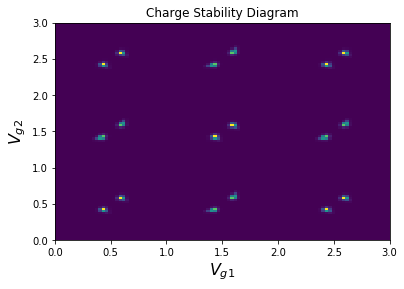

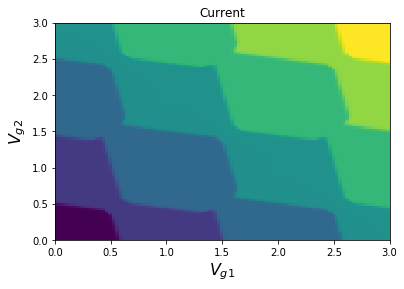

In [50]:
import itertools

kT = 1e-2
N_v = 100
V_g_vec = np.linspace(0,3,N_v)
V_g_arr = list(itertools.product(*[list(V_g_vec)]*N_dot))

import time
st = time.time()
charge = [calc_current(N_dot,x,C_mat_dot,C_mat_gate,kT) for x in V_g_arr]
print("Calculation finished in",time.time()-st,"seconds.")

# specific to 2 dot
XX,YY = np.meshgrid(V_g_vec,V_g_vec)
plt.figure(1)
plt.pcolor(XX,YY,np.array([np.sum(x[0]) for x in charge]).reshape(N_v,N_v))
plt.xlabel(r"$V_{g1}$",fontsize=16)
plt.ylabel(r"$V_{g2}$",fontsize=16)
plt.title("Charge Stability Diagram")
plt.figure(2)
plt.pcolor(XX,YY,np.array([np.sum(x[1]) for x in charge]).reshape(N_v,N_v))
plt.xlabel(r"$V_{g1}$",fontsize=16)
plt.ylabel(r"$V_{g2}$",fontsize=16)
plt.title("Current")

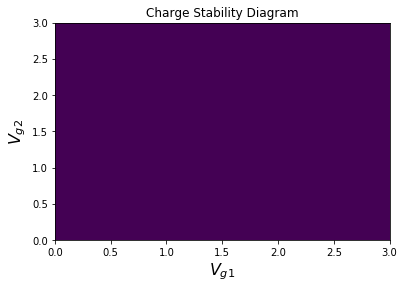

In [49]:

plt.pcolor(XX,YY,np.array([np.sum(x[0]) for x in charge]).reshape(N_v,N_v),vmax=1e-2)
plt.xlabel(r"$V_{g1}$",fontsize=16)
plt.ylabel(r"$V_{g2}$",fontsize=16)
plt.title("Charge Stability Diagram")

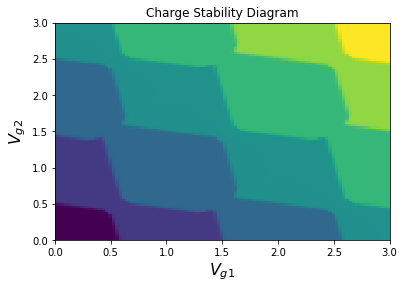

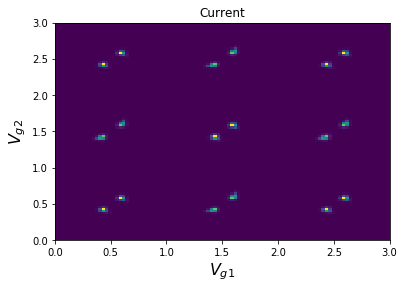

In [51]:
XX,YY = np.meshgrid(V_g_vec,V_g_vec)
plt.figure(1)
plt.pcolor(XX,YY,np.array([np.sum(x[1]) for x in charge]).reshape(N_v,N_v))
plt.xlabel(r"$V_{g1}$",fontsize=16)
plt.ylabel(r"$V_{g2}$",fontsize=16)
plt.title("Charge Stability Diagram")
plt.figure(2)
plt.pcolor(XX,YY,np.array([np.sum(x[0]) for x in charge]).reshape(N_v,N_v))
plt.xlabel(r"$V_{g1}$",fontsize=16)
plt.ylabel(r"$V_{g2}$",fontsize=16)
plt.title("Current")